In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.metrics import f1_score

In [2]:

 
class ANN:
    def __init__(self, layers_size,input_layer_node):
        self.layers_size = layers_size
        self.parameters = {}
        self.L = len(self.layers_size)
        self.n = 0
        self.batch = 0
        self.costs = []
        self.layers_size.insert(0,input_layer_node)
        self.initialize_parameters()
 
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
 
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
 
    def initialize_parameters(self):
        np.random.seed(1)
 
        for l in range(1, len(self.layers_size)):
            self.parameters["W" + str(l)] = np.random.randn(self.layers_size[l], self.layers_size[l - 1]) / np.sqrt(
                self.layers_size[l - 1])
            self.parameters["b" + str(l)] = np.zeros((self.layers_size[l], 1))
 
    def forward(self, X):
        store = {}
 
        A = X.T
        for l in range(self.L - 1):
            Z = self.parameters["W" + str(l + 1)].dot(A) + self.parameters["b" + str(l + 1)]
            A = self.sigmoid(Z)
            store["A" + str(l + 1)] = A
            store["W" + str(l + 1)] = self.parameters["W" + str(l + 1)]
            store["Z" + str(l + 1)] = Z
 
        Z = self.parameters["W" + str(self.L)].dot(A) + self.parameters["b" + str(self.L)]
        A = self.softmax(Z)
        store["A" + str(self.L)] = A
        store["W" + str(self.L)] = self.parameters["W" + str(self.L)]
        store["Z" + str(self.L)] = Z
 
        return A, store
 
    def sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return s * (1 - s)
 
    def backward(self, X, Y, store):
 
        derivatives = {}
 
        store["A0"] = X.T
 
        A = store["A" + str(self.L)]
        dZ = A - Y.T
 
        dW = dZ.dot(store["A" + str(self.L - 1)].T) / self.batch
        db = np.sum(dZ, axis=1, keepdims=True) / self.batch
        dAPrev = store["W" + str(self.L)].T.dot(dZ)
 
        derivatives["dW" + str(self.L)] = dW
        derivatives["db" + str(self.L)] = db
 
        for l in range(self.L - 1, 0, -1):
            dZ = dAPrev * self.sigmoid_derivative(store["Z" + str(l)])
            dW = 1. / self.batch * dZ.dot(store["A" + str(l - 1)].T)
            db = 1. / self.batch * np.sum(dZ, axis=1, keepdims=True)
            if l > 1:
                dAPrev = store["W" + str(l)].T.dot(dZ)
 
            derivatives["dW" + str(l)] = dW
            derivatives["db" + str(l)] = db
 
        return derivatives


    def create_mini_batches(self,X, y, batch_size):
        
        mini_batches = []
        data = np.hstack((X, y))
        np.random.shuffle(data)
        n_minibatches = data.shape[0] // batch_size
        i = 0
     
        for i in range(n_minibatches + 1):
            mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
            X_mini = mini_batch[:, :-10]
            Y_mini = mini_batch[:, -10:].reshape((-1, 10))
            mini_batches.append((X_mini, Y_mini))
        if data.shape[0] % batch_size != 0:
            mini_batch = data[i * batch_size:data.shape[0]]
            X_mini = mini_batch[:, :-10]
            Y_mini = mini_batch[:, -10:].reshape((-1, 10))
            mini_batches.append((X_mini, Y_mini))
        return mini_batches
 
    def fit(self, X, Y, learning_rate=1, n_iterations=10,batch=32):
        np.random.seed(1)
        self.batch = batch
        #self.n = X.shape[0]
        #self.layers_size.insert(0, X.shape[1])
        #self.initialize_parameters()
        for loop in range(n_iterations):

            mini_batches = self.create_mini_batches(X, Y, self.batch)
            loss = 0
            acc = 0
            for mini_batch in mini_batches:
                X_mini, y_mini = mini_batch
                A, store = self.forward(X_mini)
                loss += -1*np.mean(y_mini * np.log(A.T+ 1e-8))# CCE cost function A.T is updated weight 
                derivatives = self.backward(X_mini, y_mini, store)
     
                for l in range(1, self.L + 1):
                    self.parameters["W" + str(l)] = self.parameters["W" + str(l)] - learning_rate * derivatives[
                        "dW" + str(l)]
                    self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - learning_rate * derivatives[
                        "db" + str(l)]

                acc += self.predict(X_mini, y_mini)

            
            self.costs.append(loss)
            print("Epoch",loop+1,"\steps ",len(mini_batches),"Train loss: ", "{:.4f}".format(loss/len(mini_batches)),
                                                "Train acc:", "{:.4f}".format(acc/len(mini_batches)))
                    
                
                    

    def save_weights(self):
        np.save("weights.npy",ann.parameters ,allow_pickle=True)
    
    def load_weights(self,dir):
        
        weights=np.load(dir,allow_pickle=True)
        for i in ann.parameters.keys():
            ann.parameters[str(i)] = weights.item().get(str(i))
            
        print('Weight loaded')
        
    def predict(self, X, Y):
        A, cache = self.forward(X)
        y_hat = np.argmax(A, axis=0)
        Y = np.argmax(Y, axis=1)
        accuracy = (y_hat == Y).mean()
        return accuracy
 
    def plot_cost(self):
        plt.figure()
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.xlabel("epochs")
        plt.ylabel("Loss")
        plt.grid()
        plt.show()


    def compute_f1_score(self, X, Y):
        A, _ = self.forward(X)
        y_pred = np.argmax(A, axis=0)
        Y_true = np.argmax(Y, axis=1)
        return f1_score(Y_true, y_pred, average='weighted')


def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    #one_hot_Y = one_hot_Y.T
    return one_hot_Y

def load_mnist():
    
    data = pd.read_csv("/Users/aditya/Downloads/fashion-mnist_train.csv") 
    X,y = data.iloc[:,1:], data.iloc[:,0] #separate feature and class_label
    #convert to nnumpy array
    X = np.asarray(X)
    y = np.asarray(y)
    #Normalize samples
    X = X / 255.
    y = one_hot(y)
    data = pd.read_csv("/Users/aditya/Downloads/fashion-mnist_test.csv") 
    X1,y1 = data.iloc[:,1:], data.iloc[:,0] #separate feature and class_label
    #convert to nnumpy array
    X1 = np.asarray(X1)
    y1 = np.asarray(y1)
    #Normalize samples
    X1 = X1/ 255.
    y1 = one_hot(y1)
    
    return  X , X1 , y , y1 

<>:126: SyntaxWarning: invalid escape sequence '\s'
<>:126: SyntaxWarning: invalid escape sequence '\s'
C:\Users\aditya\AppData\Local\Temp\ipykernel_5580\2157404229.py:126: SyntaxWarning: invalid escape sequence '\s'
  print("Epoch",loop+1,"\steps ",len(mini_batches),"Train loss: ", "{:.4f}".format(loss/len(mini_batches)),


In [3]:
if __name__ == '__main__':
    train_x , test_x , train_y , test_y = load_mnist()
    
    layers_dims = [10, 10]
    
    ann = ANN(layers_dims,train_x.shape[1])
    ann.fit(train_x, train_y, learning_rate=.1, n_iterations=100,batch=64)

Epoch 1 \steps  939 Train loss:  0.1119 Train acc: 0.6877
Epoch 2 \steps  939 Train loss:  0.0656 Train acc: 0.7815
Epoch 3 \steps  939 Train loss:  0.0563 Train acc: 0.8133
Epoch 4 \steps  939 Train loss:  0.0517 Train acc: 0.8335
Epoch 5 \steps  939 Train loss:  0.0491 Train acc: 0.8437
Epoch 6 \steps  939 Train loss:  0.0473 Train acc: 0.8513
Epoch 7 \steps  939 Train loss:  0.0461 Train acc: 0.8552
Epoch 8 \steps  939 Train loss:  0.0451 Train acc: 0.8591
Epoch 9 \steps  939 Train loss:  0.0443 Train acc: 0.8628
Epoch 10 \steps  939 Train loss:  0.0437 Train acc: 0.8641
Epoch 11 \steps  939 Train loss:  0.0429 Train acc: 0.8676
Epoch 12 \steps  939 Train loss:  0.0424 Train acc: 0.8677
Epoch 13 \steps  939 Train loss:  0.0421 Train acc: 0.8705
Epoch 14 \steps  939 Train loss:  0.0416 Train acc: 0.8721
Epoch 15 \steps  939 Train loss:  0.0413 Train acc: 0.8730
Epoch 16 \steps  939 Train loss:  0.0409 Train acc: 0.8756
Epoch 17 \steps  939 Train loss:  0.0405 Train acc: 0.8763
Epoch 


Train Accuracy: 0.8872
Test Accuracy: 0.8616


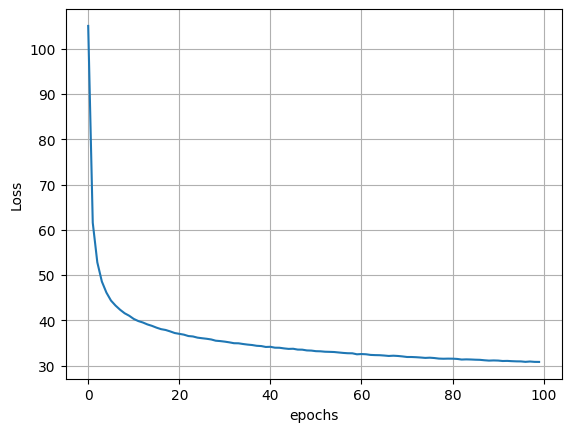

In [4]:
print("\nTrain Accuracy:", "{:.4f}".format(ann.predict(train_x, train_y)))
print("Test Accuracy:", ann.predict(test_x, test_y))
ann.plot_cost()

In [5]:
f1 = ann.compute_f1_score(test_x, test_y)
print("Test F1 Score:", f1)


Test F1 Score: 0.8603414201963229
